# Stochastic Kinematically Informed Earthquake Sequences (SKIES)

1. Calculate kinematically informed random epicenter
   $$P(c(t)) = \frac{1}{1+e^{-c(t)}} + \mathrm{history}$$
   where $c(t)$ is the coupling rate at time ($t$). This is an instantaneous formulation. We could also do this with a more history dependent formulation. This could include dropping probabilities after an event ruptures a triangular element much like a "state" effect. This could sort of halo certain regions
2. Calculate random magnitude from Gutenberg-Richter distribution with a minimum magnitude based on minimum triangle area
3. Calculate approximate rupture area, $a$ with empirical scaling law (Allen and Hayes, 2017)
4. Find subset of $n$ triangles with areas $a_n$ that sum to $a$ some factor
5. Calculate eigenfunctions for these triangles
6. Generate random Gaussian slip pattern from randomly weighted eigenvectors
7. Sigmoid scaling of slip with distance from the hypocenter so that it tapers to zero at rupture edge
8. Rescale random Gaussian slip pattern to get the magnitude correct

# This model is consistent with:

1. Gutenberg-Richter magnitude-frequency distribution
2. Utsu-Omori aftershock decay rate
3. Empirical moment magnitude to rupture area scaling laws (bi-linear Allen and Hayes, 2017)
4. Crack theory for rupture shape (circular small earthquakes)
5. Geometric fault limits on rupture width and shape
6. Estimated roughness of coseismic slip distributions
7. Earthquake slip is probabilistically focused on regions with accumulated slip deficits
8. Co-seismic and inter-seismic moment balance (can be adjusted for imbalance)
9. Geodetically constrained decadal-scale interseismic fault coupling


In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import datetime
import json
import meshio
import os
import warnings
import scipy
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
from ismember import ismember
import colorcet as cc
import matplotlib
import skies


In [3]:
FONTSIZE = 12


In [5]:
run_name = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
base_runs_folder = "./runs/"
output_path = os.path.join(base_runs_folder, run_name)
mesh_parameters_file_name = "./data/western_north_america_mesh_parameters.json"
skies.create_output_folder(base_runs_folder, output_path)
meshes = skies.read_meshes(mesh_parameters_file_name)
skies.print_magnitude_overview(meshes)


Warning: The file contains tag data that couldn't be processed.

AttributeError: 'list' object has no attribute 'areas'

In [7]:
# Set initial conditions with accumulated slip
sources = addict.Dict()
sources.lon = np.array([235.779])
sources.lat = np.array([45.553])
sources.magnitude = np.array([10.0])
sources.slip_type = ["dip_slip"]
initial_slip_deficit = skies.get_synthetic_accumulated_slip(meshes[0], sources)
initial_dip_slip_deficit = initial_slip_deficit[1::2]

# Load initial slip defict and multiply by time cascadia_low_resolution_tde_dip_slip_rates.npy
# FIX: Here I am implicity mapping mm/yr to meters.  FIX THIS.
initial_dip_slip_deficit = np.load("./data/cascadia_low_resolution_tde_dip_slip_rates.npy")

total_coseismic_slip = np.zeros_like(initial_dip_slip_deficit)
skies.plot_initial_data(meshes, initial_dip_slip_deficit)


TypeError: plot_initial_data() missing 1 required positional argument: 'output_folder'

In [8]:
KM2_TO_M2 = 1e6  # kilometers squared to meters squared


def plot_event_clean(
    event,
    meshes,
    pre_event_slip_deficit,
    probability,
    post_event_slip_deficit,
    t,
    iteration_step,
):
    # Plot distances from current event hypocenter triangle
    plt.figure(figsize=(15, 5))

    # Plot pre-earthquake slip deficit
    plt.subplot(1, 3, 1)
    pc = skies.plot_meshes(meshes, pre_event_slip_deficit, plt.gca(), "magma_r")
    plt.colorbar(pc, label="initial slip deficit (m)")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(f"pre-earthquake slip deficit")

    # Plot slip distribution
    plt.subplot(1, 3, 2)
    fill_value = np.zeros(meshes[0].n_tde)
    fill_value[event.triangle_index] = event.slip
    x_coords = meshes[0].meshio_object.points[:, 0]
    y_coords = meshes[0].meshio_object.points[:, 1]
    vertex_array = np.asarray(meshes[0].verts)
    ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts,
        edgecolor=None,
        cmap="gnuplot2_r",
        linewidth=0,
        alpha=1.0,
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.gca().set_aspect("equal")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.colorbar(pc, label="slip (m)")
    plt.title(f"M = {event.moment_magnitude[0]:0.3}")

    plt.subplot(1, 3, 3)
    pc = skies.plot_meshes(meshes, post_event_slip_deficit, plt.gca(), "magma_r")
    plt.colorbar(pc, label="slip deficit (m)")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(f"post-earthquake slip deficit")

    # plt.suptitle(f"{iteration_step=}, {t=}")
    plt.show()


def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = matplotlib.path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


# def rbf_interpolate(fill_value):
#     # Observation coordinates and data
#     x_vec = np.linspace(231, 239, N_GRID_X)
#     y_vec = np.linspace(38, 52, N_GRID_Y)
#     x_mat, y_mat = np.meshgrid(x_vec, y_vec)
#     y_mat = y_mat
#     centroids_lon = meshes[0].centroids[:, 0]
#     centroids_lat = meshes[0].centroids[:, 1]
#     centroids_val = fill_value

#     # Package for RBFInterpolator
#     xgrid = np.stack((x_mat, y_mat))
#     xflat = xgrid.reshape(2, -1).T
#     xobs = np.vstack((centroids_lon, centroids_lat)).T
#     yobs = centroids_val
#     yflat = scipy.interpolate.RBFInterpolator(
#         xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
#     )(xflat)
#     ygrid = yflat.reshape(N_GRID_X, N_GRID_Y)
#     return xgrid, ygrid


def rbf_interpolate2(fill_value):
    # Observation coordinates and data
    x_vec = np.linspace(231, 239, N_GRID_X)
    y_vec = np.linspace(38, 52, N_GRID_Y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    # yflat = scipy.interpolate.RBFInterpolator(
    #     xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
    # )(xflat)

    yflat = scipy.interpolate.RBFInterpolator(
        xobs, yobs, kernel="cubic", smoothing=0.00, epsilon=1.0
    )(xflat)
    ygrid = yflat.reshape(N_GRID_X, N_GRID_Y)
    return xgrid, ygrid


i=0
np.sum(pre_event_slip_deficit > 0)=1705


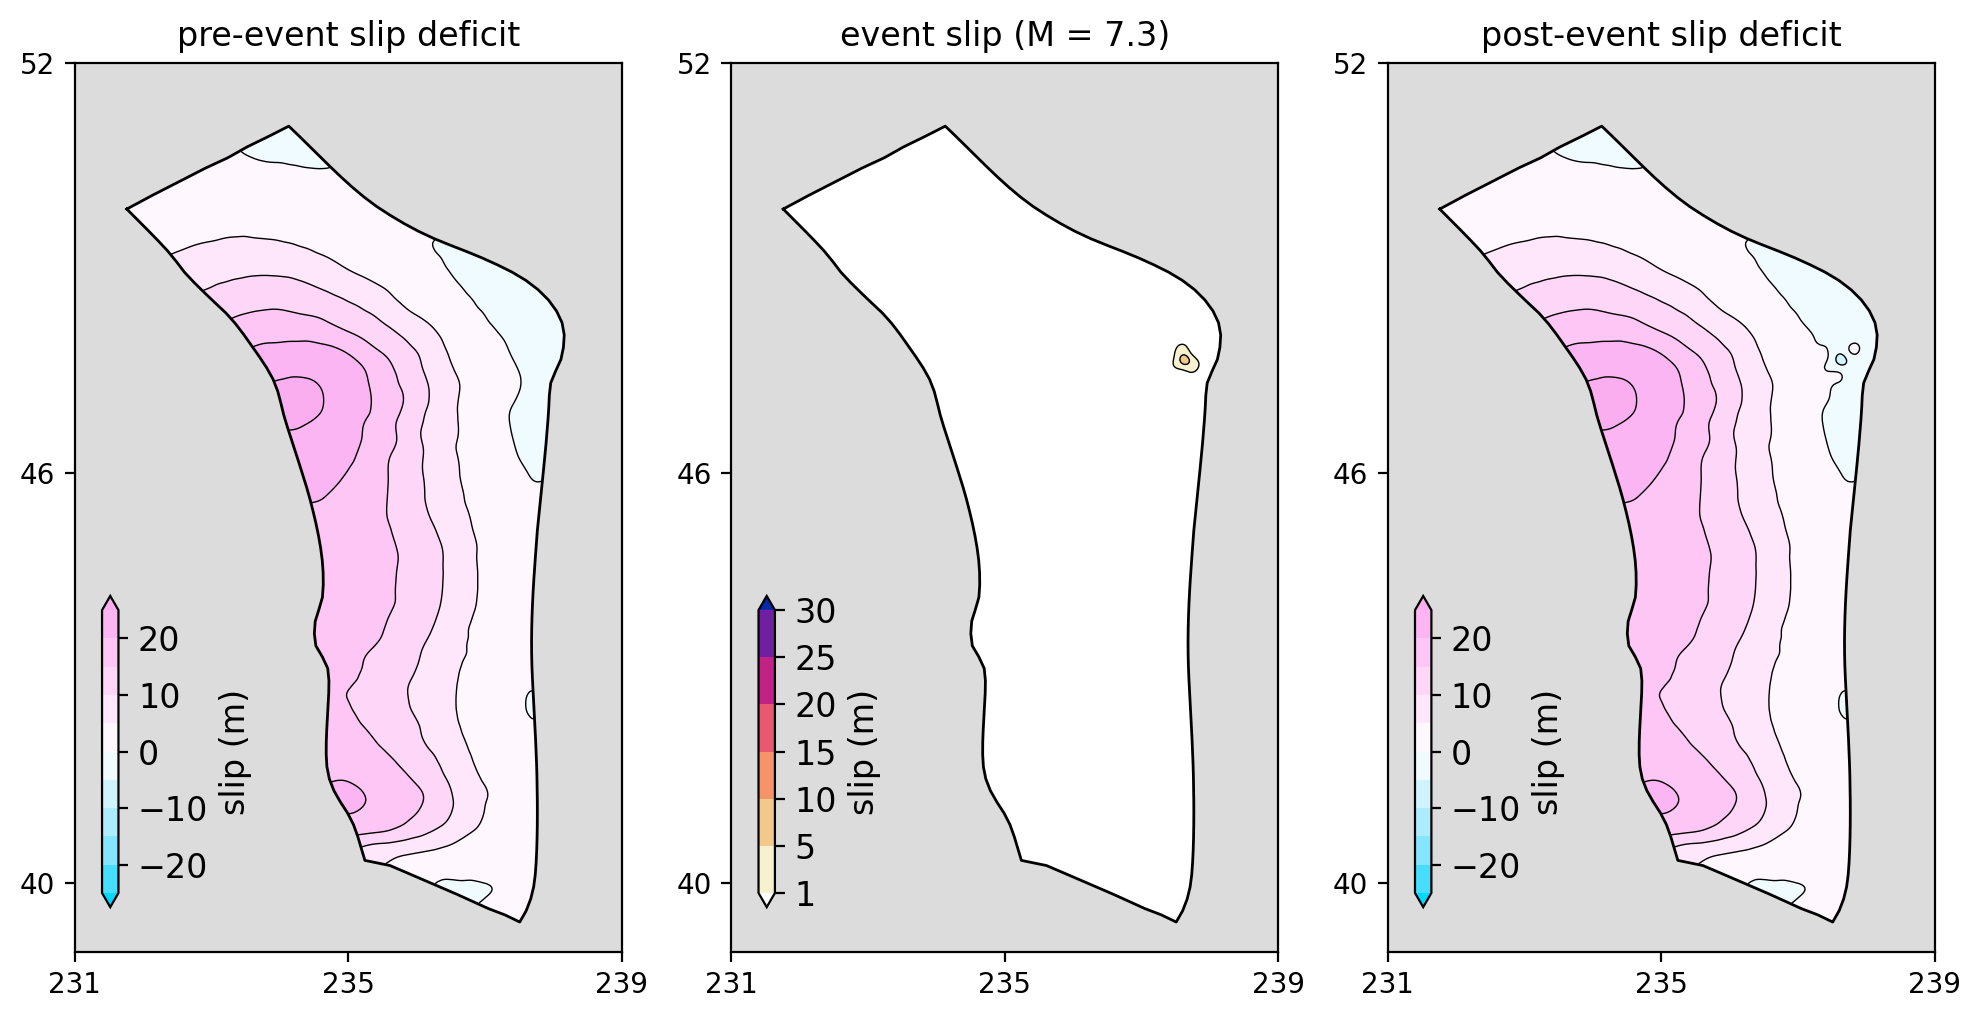

In [9]:
t = 0
N_GRID_X = 500
N_GRID_Y = 500
pre_event_slip_deficit = initial_dip_slip_deficit

plt.figure(figsize=(12, 6))
for i in range(1):
    print(f"{i=}")
    print(f"{np.sum(pre_event_slip_deficit > 0)=}")

    # Only go through the event generation process of there is positive slip deficit somewhere
    if np.sum(pre_event_slip_deficit > 0) > 0:
        # Generate event
        location_probability = skies.get_location_probability(pre_event_slip_deficit)
        event = skies.create_event(meshes, location_probability)
        total_coseismic_slip += event.slip_all_elements
        post_event_slip_deficit = pre_event_slip_deficit - event.slip_all_elements

        # Pre-earthquake slip deficit
        plt.subplot(1, 3, 1)
        cmap = cc.cm.CET_D10
        # levels = np.linspace(-25, 25, 10)
        levels = np.arange(-25, 30, 5)
        xgrid, ygrid = rbf_interpolate2(pre_event_slip_deficit)
        xflat = xgrid.reshape(2, -1).T
        inpolygon_vals = inpolygon(
            xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
        )
        inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
        ygrid[~inpolygon_vals] = np.nan
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        cb = plt.colorbar(
            cax=plt.gca().inset_axes((0.05, 0.05, 0.03, 0.35)), label="slip (m)"
        )
        cb.set_label(label="slip (m)", size=12)
        cb.ax.tick_params(labelsize=12)
        plt.contour(
            *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.5, levels=levels
        )
        plt.gca().set_aspect("equal", adjustable="box")
        plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
        plt.gca().set_facecolor("gainsboro")
        plt.xlim([231, 239])
        plt.ylim([39, 52])
        plt.xticks([231, 235, 239])
        plt.yticks([40, 46, 52])
        plt.title("pre-event slip deficit")

        # Earthquake slip
        plt.subplot(1, 3, 2)
        cmap = cc.cm.CET_L17
        # levels = np.linspace(0, 10, 10)
        levels = np.arange(1, 11, 1)
        levels = np.array([1, 5, 10, 15, 20, 25, 30])

        xgrid, ygrid = rbf_interpolate2(event.slip_all_elements)
        xflat = xgrid.reshape(2, -1).T
        inpolygon_vals = inpolygon(
            xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
        )
        inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
        ygrid[~inpolygon_vals] = np.nan
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        cb = plt.colorbar(
            cax=plt.gca().inset_axes((0.05, 0.05, 0.03, 0.35)), label="slip (m)"
        )
        cb.set_label(label="slip (m)", size=12)
        cb.ax.tick_params(labelsize=12)
        plt.contour(
            *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.5, levels=levels
        )
        plt.gca().set_aspect("equal", adjustable="box")
        plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
        plt.gca().set_facecolor("gainsboro")
        plt.xlim([231, 239])
        plt.ylim([39, 52])
        plt.xticks([231, 235, 239])
        plt.yticks([40, 46, 52])
        plt.title(f"event slip (M = {event.moment_magnitude[0]:0.2})")

        # Post-earthquake slip deficit
        plt.subplot(1, 3, 3)
        levels = np.arange(-25, 30, 5)
        cmap = cc.cm.CET_D10
        xgrid, ygrid = rbf_interpolate2(post_event_slip_deficit)
        xflat = xgrid.reshape(2, -1).T
        inpolygon_vals = inpolygon(
            xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
        )
        inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
        ygrid[~inpolygon_vals] = np.nan
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        cb = plt.colorbar(
            cax=plt.gca().inset_axes((0.05, 0.05, 0.03, 0.35)), label="slip (m)"
        )
        cb.set_label(label="slip (m)", size=12)
        cb.ax.tick_params(labelsize=12)
        plt.contour(
            *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.5, levels=levels
        )
        plt.gca().set_aspect("equal", adjustable="box")
        plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
        plt.gca().set_facecolor("gainsboro")
        plt.xlim([231, 239])
        plt.ylim([39, 52])
        plt.xticks([231, 235, 239])
        plt.yticks([40, 46, 52])
        plt.title("post-event slip deficit")

        pre_event_slip_deficit = np.copy(post_event_slip_deficit)
plt.savefig("single_event_timestep_contour_M9.pdf")
plt.savefig("single_event_timestep_contour_M9.png", dpi=500)
plt.show()

In [ ]:
# TODO: #10 Write up eigenvalue shape idea
# TODO: #11 Revisit probability calcuation with sigmoid.  We're generating occasional Nans
# TODO: #15 Write up theory for time probability
# TODO: #14 Code 1D time series example with: 1) loading, 2) coseismic jumps, 2) Omori like decay after earthquake


In [ ]:
event.slip.max()


38.81703057596513

In [ ]:
# print(f"event slip (M = {event.moment_magnitude:0.3})")
print(f"{event.moment_magnitude[0]:0.2f}")



8.70
